# Tutorial Auto-Tagging using different front-end/ different architecture

- date: 2024-10-10
- author: geoffroy.peeters@telecom-paris.fr

This notebook was created for the tutorial held at ISMIR-2024 "Deep-Learning 101 for Audio-based Music Information Retrieval".
It illustrates the use of various deep-learning bricks to solve the task of "Auto-Tagging".

Part of the code is based on 
- SincNet model: https://github.com/mravanelli/SincNet/blob/master/dnn_models.py 

Datasets are available at
- GTZAN-Genre 
- MTT (Magna-Tag-a-Tune) https://mirg.city.ac.uk/codeapps/the-magnatagatune-dataset

The two datasets illustrate different type of problems.
- GTZAN-Genre is a multi-class problem (classification into 10 mutually exclusive classes)
- MTT (Magna-Tag-a-Tune) is a multi-label (classification into 10 non-mutually exclusive tags)

## Deployment

In case the notebook is run on GoogleColab or others, we first need to
- get the packages: `git clone``
- get the datasets

We also test the models on two different datasets:
- GTZAN-Genre
- MTT (Magna-Tag-A-Tune)

In [72]:
do_deploy = False

if do_deploy:
    !git clone https://github.com/geoffroypeeters/deeplearning-101-audiomir_notebook.git
    %cd deeplearning-101-audiomir_notebook
    !ls

    import urllib.request
    import shutil
    ROOT = 'https://perso.telecom-paristech.fr/gpeeters/tuto_DL101forMIR/'
    
    #hdf5_audio_file, pyjama_annot_file = 'gtzan-genre_audio.hdf5.zip', 'gtzan-genre.pyjama'
    hdf5_audio_file, pyjama_annot_file = 'mtt_audio.hdf5', 'mtt.pyjama'
    
    urllib.request.urlretrieve(ROOT + hdf5_audio_file, hdf5_audio_file)
    if hdf5_audio_file.endswith('.zip'): shutil.unpack_archive(hdf5_audio_file, './')
    urllib.request.urlretrieve(ROOT + pyjama_annot_file, pyjama_annot_file)

    ROOT = './'

else:

    ROOT = '/tsi/data_doctorants/gpeeters/_data/'

base, problem, annot_key = 'gtzan-genre', 'multiclass', 'genre'
#base, problem, annot_key = 'mtt', 'multilabel', 'tag'

## Import packages

In [73]:
import torch
import torch.nn as nn
import torch.nn.functional as F
#import torchaudio
from torch.utils.data import Dataset
import torch.optim as optim
import torchsummary

! pip install lightning --quiet
import lightning.pytorch as pl
from lightning.pytorch.callbacks import Callback
from lightning.pytorch.callbacks import EarlyStopping, ModelCheckpoint

! pip install wandb --quiet
import wandb
from pytorch_lightning.loggers import WandbLogger

import json
import yaml
import h5py
import pprint as pp
from tqdm import tqdm
import datetime
from multiprocessing import Pool
import os

import librosa
import numpy as np
import matplotlib.pyplot as plt
import feature
plt.rcParams['figure.figsize'] = [15, 10]
import IPython.display

# -----------------------------
import model_factory 
import importlib
importlib.reload(model_factory) 

from argparse import Namespace
! pip install munch --quiet
from munch import munchify

## Parameters

In [74]:
hdf5_audio_file = f'{ROOT}/{base}_audio.hdf5'
pyjama_annot_file = f'{ROOT}/{base}.pyjama'


do_feature = 'lms'#, 'waveform', 'lms'
param_lms = Namespace()
param_lms.nb_band = 128
param_lms.L_n = 2048
param_lms.STEP_n = 1024

param_patch = Namespace()
param_model = Namespace()
if do_feature == 'waveform':
    param_patch.L_frame = 3200
    param_model.n_in = 1
elif do_feature == 'lms':
    param_patch.L_frame = 64
    param_model.n_in = param_lms.nb_band
param_patch.STEP_frame = int(param_patch.L_frame/2)

param_model.T_in = param_patch.L_frame
param_model.n_out = 10
param_model.batch_size = 128
param_model.device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

param_lightning = Namespace()
param_lightning.max_epochs = 500
param_lightning.dirpath='my_model/'
param_lightning.filename='best_model'


## Dataloader

### Test loading pyjama/hdf5

All the audio data of a dataset are stored in a single [.hdf5](https://docs.h5py.org/) file.
Each `key` corresponds to an entry, a specific audiofile.
Its array contains the audio wavform and the attribute `sr_hz` provides its sampling rate.

All the annotations of a dataset are stored in a single *.pyjama file.
As [JAMS](https://github.com/marl/jams) files, .pyjama files are JSON files.
However, a single .pyjama file can contain the annotations of ALL entries of a dataset.
Its specifications are described here [DOC](https://github.com/geoffroypeeters/pyjama).
The values of the `filepath` field of the .pyjama file correspond to the `key` values of the .hdf5 file.

We want to solve `multi-class` and `multi-label` problem with the same code. However, in the former we have only one label per item while we can have several for the later. TO deal with this we define the functions `f_get_labelname_dict` and `f_get_groundtruth_item` that provides the list of unique labels and the labels of a given item.

In [75]:
def f_get_labelname_dict(data_d, annot_key):
    """
    description:
        provides the dictionary of labelname used in a given corpus
    """
    labelname_dict_l = []
    for entry in data_d['collection']['entry']:
        for annot in entry[annot_key]:
            labelname_dict_l.append(annot['value'])
    labelname_dict_l = list(set(labelname_dict_l))
    return sorted(labelname_dict_l)

def f_get_groundtruth_item(entry, annot_key, labelname_dict_l, problem):
    """
    description:
        map a label (or a list of labels) to a ground-truth
    """
    if problem=='multiclass':
        annot = entry[annot_key][0]
        idx_label = labelname_dict_l.index(annot['value'])
    elif problem=='multilabel':
        idx_label = np.zeros(len(labelname_dict_l))
        for annot in entry[annot_key]:
            pos = labelname_dict_l.index(annot['value'])
            idx_label[ pos ] = 1
    return idx_label


In [76]:
with open(pyjama_annot_file, encoding = "utf-8") as json_fid:
    data_d = json.load(json_fid)
entry_l = data_d['collection']['entry']

pp.pprint(entry_l[0:2])


audiofile_l = [entry['filepath'][0]['value'] for entry in entry_l]
print(f'number of audio: {len(audiofile_l)}')
pp.pprint(audiofile_l[:5])


labelname_dict_l = f_get_labelname_dict(data_d, annot_key)
print(f'number of tags: {len(labelname_dict_l)}')
pp.pprint(labelname_dict_l[:5])


with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    #audiofile_l = [key for key in hdf5_fid['/'].keys()]
    pp.pprint(f"audio shape: {hdf5_fid[audiofile_l[0]][:].shape}")
    pp.pprint(f"audio sample-rate: {hdf5_fid[audiofile_l[0]].attrs['sr_hz']}")


[{'filepath': [{'value': 'blues+++blues.00000.wav'}],
  'genre': [{'value': 'blues'}]},
 {'filepath': [{'value': 'blues+++blues.00001.wav'}],
  'genre': [{'value': 'blues'}]}]
number of audio: 1000
['blues+++blues.00000.wav',
 'blues+++blues.00001.wav',
 'blues+++blues.00002.wav',
 'blues+++blues.00003.wav',
 'blues+++blues.00004.wav']
number of tags: 10
['blues', 'classical', 'country', 'disco', 'hiphop']
'audio shape: (661794,)'
'audio sample-rate: 22050'


### Define features

We define the feature that will be used as input to the model, the `X`, and test it on an audio file.
We will use here Log-Mel-Spectrogram provided by the function `feature.f_get_lms`.

classical+++classical.00000.wav
(128, 647)


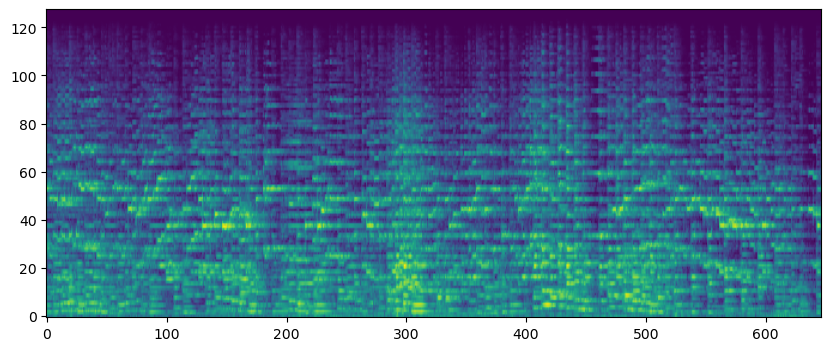

In [77]:
# --- TEST
idx_file = 100
with h5py.File(hdf5_audio_file, 'r') as hdf5_fid:
    print(audiofile_l[idx_file])
    audio_v = hdf5_fid[audiofile_l[idx_file]][:]
    sr_hz = hdf5_fid[audiofile_l[idx_file]].attrs['sr_hz']

data_m, time_sec_v = feature.f_get_lms(audio_v, sr_hz, param_lms)

plt.figure(figsize=(10,4))
print(data_m.shape)
plt.imshow(data_m, origin='lower', aspect='auto');

#### Defining patches

The input `X` of our model is actually a temporal patch/chunk of the whole feature matrix `(nb_time, nb_dim)`.
For a given feature matrix of length `T`, the function `feature.f_get_patches` provides the list of possible patches of length `L` and hop size `S` (we perform frame-analysis over the feature matrix).


In [78]:
# --- TEST
feature.f_get_patches(T=250, L=64, S=32)

[{'start_frame': 0, 'end_frame': 64},
 {'start_frame': 32, 'end_frame': 96},
 {'start_frame': 64, 'end_frame': 128},
 {'start_frame': 96, 'end_frame': 160},
 {'start_frame': 128, 'end_frame': 192},
 {'start_frame': 160, 'end_frame': 224}]

### Create Dataset

The class `PitchDataset` (a subset of pytorch `Dataset` class) is responsible for providing (with the `__getitem` method) the input `X` and ground-truth `y` of the pitches existing in a patch.

- `__getitem__`: for a given `idx_patch`, it provides the `X` (either a patch of CQT or Harmonic-CQT) tensor and the ground-truth binary pitch matrix 
- '__init__': 
  - will read the hdf5_feat_file and pyjama_annot_file
  - split their content according to training and test
  - convert the tag annotations to the format expected for `y`
  - store all the necessary data in memory (of CPU) to fasten later access: `self.data_d[key=audiofile]` for the CQT/H-CQT, `self.patch_l` for the list of all possible patch over all possibe audiofile. The `__getitem__` method simply get a patch, which audiofile it is coming from, and its position within it. 

In [79]:
from tqdm import tqdm

class TagDataset(Dataset):
    """
    description
    """

    def __init__(self, hdf5_audio_file, pyjama_annot_file, do_train):

        with open(pyjama_annot_file, encoding = "utf-8") as json_fid: data_d = json.load(json_fid)
        entry_l = data_d['collection']['entry']
        
        #entry_l = entry_l[:1000] ############### TO REMOVE ####################
        
        self.labelname_dict_l = f_get_labelname_dict(data_d, annot_key)

        self.do_train = do_train
        if self.do_train:   entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) != 0]
        else:               entry_l = [entry_l[idx] for idx in range(len(entry_l)) if (idx % 5) == 0]

        self.audio_file_l =  [entry['filepath'][0]['value'] for entry in entry_l]

        self.data_d = {}
        self.patch_l = []
        
        with h5py.File(hdf5_audio_file, 'r') as audio_fid:
            for entry in tqdm(entry_l):
                audio_file= entry['filepath'][0]['value']

                # --- get features
                if do_feature == 'waveform':    feat_value_m = audio_fid[audio_file][:].reshape(1,-1)
                elif do_feature == 'lms':       feat_value_m, _ = feature.f_get_lms(audio_fid[audio_file][:], audio_fid[audio_file].attrs['sr_hz'], param_lms)
                
                # --- map annotations
                idx_label = f_get_groundtruth_item(entry, annot_key, self.labelname_dict_l, problem)
                
                # --- store for later use
                self.data_d[audio_file] = {'X': torch.tensor(feat_value_m).float(), 'y': torch.tensor(idx_label)}
                
                # --- create list of patches and associate information
                localpatch_l = feature.f_get_patches(feat_value_m.shape[-1], param_patch.L_frame, param_patch.STEP_frame)
                for localpatch in localpatch_l:
                    self.patch_l.append({'audiofile': audio_file,
                                        'start_frame': localpatch['start_frame'],
                                        'end_frame': localpatch['end_frame'],
                                        })

    def __len__(self):
        return len(self.patch_l)

    def __getitem__(self, idx_patch):
        audiofile = self.patch_l[idx_patch]['audiofile']        
        s = self.patch_l[idx_patch]['start_frame']
        e = self.patch_l[idx_patch]['end_frame']

        X = self.data_d[ audiofile ]['X'][:,s:e]
        if do_feature == 'lms': X = X.unsqueeze(0) # --- add channel dimension
        y = self.data_d[ audiofile ]['y'] # --- We suppose the same annotation for the whole file
        return {'X':X , 'y':y}
    
train_dataset = TagDataset(hdf5_audio_file, pyjama_annot_file, do_train=True)
valid_dataset = TagDataset(hdf5_audio_file, pyjama_annot_file, do_train=False)

100%|██████████| 200/200 [00:08<00:00, 24.99it/s]


In [80]:
# --- TEST
print(len(train_dataset))
print(train_dataset[0]['X'].shape)
print(train_dataset[0]['y'].shape)

15200
torch.Size([1, 128, 64])
torch.Size([])


### Create DataLoader

We create the dataloader for the training and validation data from the corresponding dataset.


In [81]:
train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=param_model.batch_size, shuffle=True, num_workers=8, drop_last = True)
valid_dataloader = torch.utils.data.DataLoader(valid_dataset, batch_size=param_model.batch_size, shuffle=False, num_workers=8, drop_last = True)

In [82]:
# --- TEST
batch = next(iter(train_dataloader))
print(batch['X'].size())
print(batch['y'].size())

torch.Size([128, 1, 128, 64])
torch.Size([128])


## Model

The pytorch model is generated automatically based on the content of the `config_autotagging.yaml` file.

In [108]:
with open('config_autotagging.yaml', 'r') as fid: 
    cfg_dic = yaml.safe_load(fid)
config = munchify(cfg_dic)


class AutoTaggingModel(nn.Module):
    def __init__(self, config, current_input_dim):
        super(AutoTaggingModel, self).__init__()
        self.block_l = []
        for config_block in config.model.block_l:
            sequential_l = []
            for config_sequential in config_block.sequential_l:
                component_l = []
                for config_component in config_sequential.component_l:
                    module, current_input_dim = model_factory.f_parse_component(config_component[0], config_component[1], current_input_dim) 
                    component_l.append( module )
                sequential_l.append( nn.Sequential (*component_l) )
            self.block_l.append( nn.ModuleList(sequential_l) )
            self.model = nn.ModuleList(self.block_l)

    def forward(self, X, do_verbose=False):
        for idx_block, block in enumerate(self.model):
            for idx_sequential, sequential in enumerate(block):
                if do_verbose: print(f'{idx_block}/{idx_sequential}---------------------------------\n{sequential}\n> in: {X.size()}')
                X = sequential( X )
                if do_verbose: print(f'> out: {X.size()}')
        return X


if do_feature == 'waveform':
    m, C, T = 64, 1, 3200
    model = AutoTaggingModel(config, [m, C, T])
if do_feature == 'lms':
    m, C, H, W = 64, 1, 128, 64
    model = AutoTaggingModel(config, [m, C, H, W])

model = model.to(param_model.device)

### Check the model

We can check the model either using
- print(model)
- the `verbose` mode of the `forward` of the model
- the `torchsummary.summary` method

In [109]:
# --- TEST
if do_feature == 'waveform':
    m, C, T = 64, 1, 3200

    #X = torch.randn(m, C, T).to(param_model.device)
    #print(model(X, True).size())
    
    torchsummary.summary(model, input_size=(C, T))

if do_feature == 'lms':
    m, C, H, W = 64, 1, 128, 64

    #X = torch.randn(m, C, H, W).to(param_model.device)
    #print(model(X, True).size())

    torchsummary.summary(model, input_size=(C, H, W))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
         LayerNorm-1           [-1, 1, 128, 64]          16,384
            Conv2d-2            [-1, 80, 1, 60]          51,280
         nnSqueeze-3               [-1, 80, 60]               0
         LayerNorm-4               [-1, 80, 60]           9,600
         LeakyReLU-5               [-1, 80, 60]               0
           Dropout-6               [-1, 80, 60]               0
            Conv1d-7               [-1, 60, 56]          24,060
         MaxPool1d-8               [-1, 60, 18]               0
         LayerNorm-9               [-1, 60, 18]           2,160
        LeakyReLU-10               [-1, 60, 18]               0
          Dropout-11               [-1, 60, 18]               0
           Conv1d-12               [-1, 60, 14]          18,060
        MaxPool1d-13                [-1, 60, 4]               0
        LayerNorm-14                [-1

### Test the model

We can also test the model and the loss, i.e. checking that the format of the `X` corresponds to what the model is expected; and the format of the `y` and `hat_y` corresponds to what the loss is expected.
If this is OK we can start training.

In [110]:
batch = next(iter(train_dataloader))
X = batch['X'].to(param_model.device)
y = batch['y'].to(param_model.device)
hat_y = model(X)
print(f'{X.size()} {y.size()} {hat_y.squeeze(1).size()}')


torch.Size([128, 1, 128, 64]) torch.Size([128]) torch.Size([128, 10])


In [111]:
if problem=='multiclass': 
    nn.CrossEntropyLoss()(hat_y, y)
elif problem=='multilabel': 
    nn.BCEWithLogitsLoss(reduction='none')(hat_y.squeeze(1), y).size()

## Training using TorchLightning

### TorchLightning

In [113]:
def get_accuracy(hat_y, y):
    """ Manually compute accuracy """
    preds = torch.argmax(hat_y, dim=1)  # Get the predicted class (index of max logit)
    correct = (preds == y).float()  # Compare with ground truth and cast to float
    accuracy = correct.sum() / len(correct)  # Compute mean accuracy over the batch
    return accuracy

class AutoTaggingLigthing(pl.LightningModule):
    def __init__(self, in_model):
        super().__init__()
        self.model = in_model
        if problem=='multiclass': self.loss = nn.CrossEntropyLoss()
        elif problem=='multilabel': self.loss = nn.BCEWithLogitsLoss()

    def training_step(self, batch, batch_idx):
        hat_y = self.model(batch['X'])
        loss = self.loss(hat_y, batch['y'])

        self.log("train_loss", loss, prog_bar=True)
        if problem=='multiclass': 
            accuracy = get_accuracy(hat_y, batch['y'])
            self.log('train_acc', accuracy, prog_bar=True)

        return loss

    def validation_step(self, batch, batch_idx):
        hat_y = self.model(batch['X'])
        loss = self.loss(hat_y, batch['y'])
        
        self.log('val_loss', loss, prog_bar=True)
        if problem=='multiclass': 
            accuracy = get_accuracy(hat_y, batch['y'])
            self.log('val_acc', accuracy, prog_bar=True)

    def configure_optimizers(self):
        optimizer = optim.Adam(self.parameters(), 0.001)
        return optimizer

### Training

We train the model and apply a early-stopping based on the validation loss. We also monitor the accuracy.

In [114]:
my_lighting = AutoTaggingLigthing( model )
early_stop_callback = EarlyStopping(monitor="val_loss", patience=10, verbose=True, mode="min")
checkpoint_callback = ModelCheckpoint(monitor='val_loss', dirpath=param_lightning.dirpath, filename=param_lightning.filename, save_top_k=1, mode='min')
trainer = pl.Trainer(accelerator="gpu",  max_epochs = param_lightning.max_epochs, callbacks = [early_stop_callback, checkpoint_callback])
trainer.fit(model=my_lighting, train_dataloaders=train_dataloader, val_dataloaders=valid_dataloader)

/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/fabric/plugins/environments/slurm.py:204: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /home/ids/gpeeters/anaconda3/envs/conda_gpeeters_202 ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/home/ids/gpeeters/anaconda3/envs/conda_gpeeters_2024/lib/python3.8/site-packages/lightning/pytorch/callbacks/model_checkpoint.py:653: Checkpoint directory /home/ids/gpeeters/proj_tuto-ISMIR2024/code/my_model exists and is not empty.
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type             | Params
-------------------------------------------
0 | model | AutoTaggingModel | 165 K 
1 | loss  | CrossEntropyLoss | 0     
-------------------------------------------

Epoch 0: 100%|██████████| 118/118 [00:03<00:00, 39.28it/s, v_num=25, train_loss=0.779, train_acc=0.734, val_loss=1.360, val_acc=0.547]

Metric val_loss improved. New best score: 1.359


Epoch 1: 100%|██████████| 118/118 [00:04<00:00, 29.00it/s, v_num=25, train_loss=0.637, train_acc=0.766, val_loss=1.110, val_acc=0.645]

Metric val_loss improved by 0.248 >= min_delta = 0.0. New best score: 1.111


Epoch 11: 100%|██████████| 118/118 [00:04<00:00, 26.24it/s, v_num=25, train_loss=0.0545, train_acc=0.992, val_loss=1.760, val_acc=0.662]

Monitored metric val_loss did not improve in the last 10 records. Best score: 1.111. Signaling Trainer to stop.


Epoch 11: 100%|██████████| 118/118 [00:04<00:00, 26.23it/s, v_num=25, train_loss=0.0545, train_acc=0.992, val_loss=1.760, val_acc=0.662]


## Evaluation

We first load the best model obtained during training.

In [120]:
best_model_path = checkpoint_callback.best_model_path
#best_model_path = 'my_model/best_model.ckpt'
print(f"Best model saved at: {best_model_path}")
my_lighting = AutoTaggingLigthing.load_from_checkpoint(best_model_path, in_model=model)

print( type(model) )
print( type(my_lighting) )
print( type(my_lighting.model) )

model = my_lighting.model
model.to(param_model.device)

Best model saved at: /home/ids/gpeeters/proj_tuto-ISMIR2024/code/my_model/best_model-v14.ckpt
<class '__main__.AutoTaggingModel'>
<class '__main__.AutoTaggingLigthing'>
<class '__main__.AutoTaggingModel'>


AutoTaggingModel(
  (model): ModuleList(
    (0): ModuleList(
      (0): Sequential(
        (0): LayerNorm((128, 64), eps=1e-05, elementwise_affine=True)
        (1): Conv2d(1, 80, kernel_size=(128, 5), stride=(1, 1), padding=valid)
        (2): nnSqueeze()
        (3): LayerNorm((80, 60), eps=1e-05, elementwise_affine=True)
        (4): LeakyReLU(negative_slope=0.01)
        (5): Dropout(p=0, inplace=False)
      )
      (1): Sequential(
        (0): Conv1d(80, 60, kernel_size=(5,), stride=(1,))
        (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (2): LayerNorm((60, 18), eps=1e-05, elementwise_affine=True)
        (3): LeakyReLU(negative_slope=0.01)
        (4): Dropout(p=0, inplace=False)
      )
      (2): Sequential(
        (0): Conv1d(60, 60, kernel_size=(5,), stride=(1,))
        (1): MaxPool1d(kernel_size=3, stride=3, padding=0, dilation=1, ceil_mode=False)
        (2): LayerNorm((60, 4), eps=1e-05, elementwise_affine=True)
        (

### Multi-class/multi-label: performance measures using scikitlearn

We send all the data of the validation dataset to the model, get the estimated pitch `hat_y`.

- For **multiclass**, we then choose the most-likely class for each item `np.argmax` and compute the `recall`, `precision`, `f-measure`, `accuracy`.
- For **multilabel**, we preserve the probability outputs, and evaluate the results for various possible threshold using the `roc_auc_score` and `average_precision_score`.


In [121]:
if problem=='multiclass':
    y_idx_l = []
    hat_y_idx_l = []
    for batch in valid_dataloader:
        hat_y_prob = model(batch['X'].to(param_model.device))
        y_idx_l.append(batch['y'].numpy())
        hat_y_idx_l.append(np.argmax(hat_y_prob.detach().cpu().numpy(), axis=1))
    y_idx_v = np.concatenate(y_idx_l)
    hat_y_idx_v = np.concatenate(hat_y_idx_l)
    print(y_idx_v.shape)
    print(hat_y_idx_v.shape)

    from sklearn.metrics import classification_report, confusion_matrix
    classification_reports = classification_report(y_true=y_idx_v, y_pred=hat_y_idx_v, output_dict=True, zero_division=0)
    pp.pprint(classification_reports['macro avg'])
    cm = confusion_matrix(y_true=y_idx_v, y_pred=hat_y_idx_v)
    print(cm)
    # --- accuracy: np.sum(np.diag(cm))/np.sum(cm)
    # --- recall: for c in range(10): print(cm[c,c]/np.sum(cm[c,:]))

elif problem=='multilabel':
    y_ohe_l = []
    hat_y_prob_l = []
    for batch in valid_dataloader:
        hat_y_prob = F.sigmoid(model(batch['X'].to(param_model.device)))
        if problem=='multiclass':       y_ohe_l.append(F.one_hot(batch['y'], 10).numpy())
        elif problem=='multilabel':     y_ohe_l.append(batch['y'].numpy())
        hat_y_prob_l.append(hat_y_prob.detach().cpu().numpy())
    y_ohe_m = np.concatenate(y_ohe_l) # --- convert list to array
    hat_y_prob_m = np.concatenate(hat_y_prob_l)

    # --- remove classes that do not appear in the validation set
    mask = np.sum(y_ohe_m, axis=0)>0
    y_ohe_m = y_ohe_m[:,mask]
    hat_y_prob_m = hat_y_prob_m[:,mask]

    from sklearn.metrics import roc_auc_score, average_precision_score
    auc = roc_auc_score(y_true=y_ohe_m, y_score=hat_y_prob_m, average="macro")
    print(f'auc: {auc}')
    average_precision = average_precision_score(y_true=y_ohe_m, y_score=hat_y_prob_m, average="macro")
    print(f'average_precision: {average_precision}')

(3712,)
(3712,)
{'f1-score': 0.6110496195077048,
 'precision': 0.6400344656965543,
 'recall': 0.6322458543619323,
 'support': 3712.0}
[[236   9  45   8   1  67   0   3  10   1]
 [  0 366   0   0   0  12   0   2   0   0]
 [  4  20 263   8   6  44   0  24   2   9]
 [ 44   0  39 201  31   9   3  35  15   3]
 [ 33   6   5  20 217  16  40  42   1   0]
 [  5  52  16   0   0 305   0   2   0   0]
 [ 23   0  19  11   4   0 304   0   0  19]
 [  0   7  17   1   0  11   0 333   8   3]
 [ 22   5  34  41  37  43   2  49 145   2]
 [ 33  20 100  17  20  18  15  38   6  25]]


### Illustration: tag-o-gram

We illustrate the results obtained by the trained model on a given audio.

(19, 10)


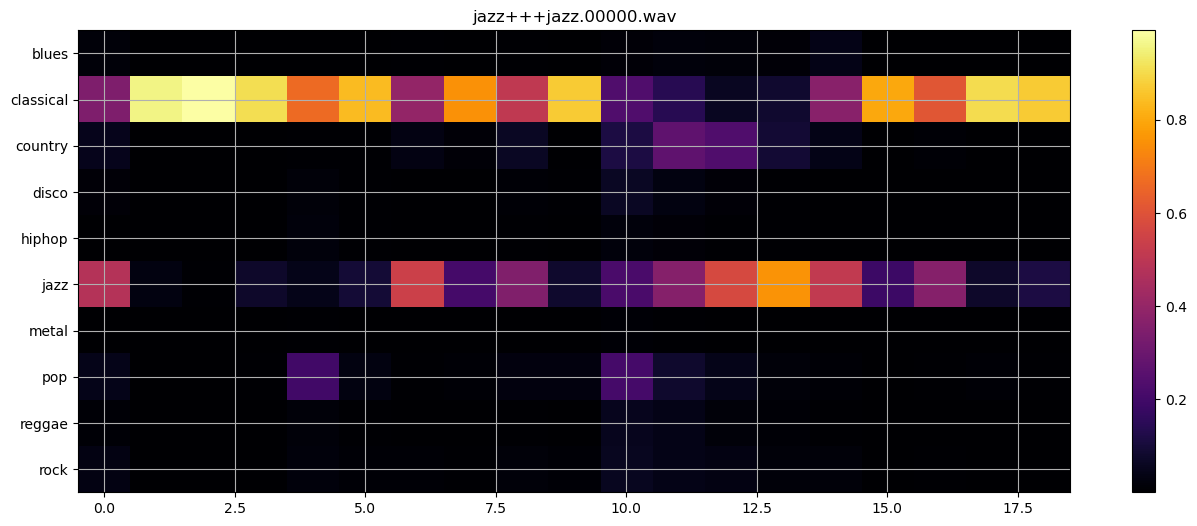

In [122]:
def F_tag_o_gram(model, audio_v, sr_hz):
    """
    """
    # --- Compute the audio features
    if do_feature == 'waveform':    feat_value_m = audio_v.reshape(1,-1)
    elif do_feature == 'lms':       feat_value_m, _ = feature.f_get_lms(audio_v, sr_hz, param_lms)
                
    # --- Split matrix into patches
    nb_frame = feat_value_m.shape[1]
    patch_info_l = feature.f_get_patches(feat_value_m.shape[-1], param_patch.L_frame, param_patch.STEP_frame)
    nb_patch = len(patch_info_l)
    data_3m = np.zeros((nb_patch, feat_value_m.shape[0], param_patch.L_frame))
    for idx in range(nb_patch):
        data_3m[idx, :, :] = feat_value_m[:, patch_info_l[idx]['start_frame']:patch_info_l[idx]['end_frame']]

    # --- Convert numpy to torch tensor
    X = torch.from_numpy(data_3m).float().to(param_model.device)
    if do_feature == 'lms': X = X.unsqueeze(1) # --- add channel dimension

    # --- Get prediction from model
    model.eval()
    y_hat = model(X)
    if problem=='multiclass':       predicted = F.softmax(y_hat, dim=1)
    elif problem=='multilabel':     predicted = F.sigmoid(y_hat)
    # --- Convert from torch tensor to numpy
    y_hat_m = predicted.cpu().detach().numpy()
    print(y_hat_m.shape)

    fig, axes = plt.subplots(1, 1, figsize=(16, 6))
    im = axes.imshow(y_hat_m.T, aspect='auto', interpolation=None, cmap=plt.get_cmap('inferno'))
    axes.set_yticks(np.arange(0,len(valid_dataset.labelname_dict_l)))
    axes.set_yticklabels(valid_dataset.labelname_dict_l)
    axes.grid(True)
    fig.colorbar(im, orientation='vertical')

    return


# ---------------------------------------------
# ---------------------------------------------
# ---------------------------------------------
audio_file= valid_dataset.audio_file_l[100]

with h5py.File(hdf5_audio_file, 'r') as audio_fid:
    audio_value_v = audio_fid[audio_file][:]
    audio_sr_hz = audio_fid[audio_file].attrs['sr_hz']
F_tag_o_gram(model, audio_value_v, audio_sr_hz)
plt.title(audio_file)
IPython.display.Audio(data=audio_value_v, rate=audio_sr_hz)

### Display learned filters Conv1D

In [92]:
#weight = model.frontend[1].weight # --- conv1D
#weight = model.frontend[1].filters # --- SincNet
named_modules_dict = dict(model.named_modules())
#weight = named_modules_dict['model.0'][1].weight
weight = named_modules_dict['model.0'][1].filters

AttributeError: 'Sequential' object has no attribute 'filters'

In [ ]:
plt.figure(figsize=(10,10))
nb_filter = weight.size()[0]
nb_filter = 40
for num_filter in range(nb_filter):
    value = weight[num_filter,:,:].squeeze().detach().cpu() # --- conv1D
    plt.subplot(nb_filter, 2, 2*num_filter+1)
    plt.plot( value ); plt.title(num_filter)
    plt.subplot(nb_filter, 2, 2*num_filter+2)
    plt.plot(np.abs(np.fft.rfft(value)) ); plt.title(num_filter)

### Display learned filters SincNet